# Fewshot segmentation experiment 
J.Cristiano     
10/22/2024     

The purpose of this notebook is to use a few segmentations of brace root images to enhance segmentations of brace roots.    
I might also take a second look at the key difference between SAM2 and FSmedSAM2 (removal of 
object_score_logits) as well as consider the feasibility of Strictly One Shot Few Query technique.

In [2]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 KB 8.1 MB/s eta 0:00:00a 0:00:01


In [1]:
import json
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import cv2
coco = COCO('/work/images/best_annot.json')


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


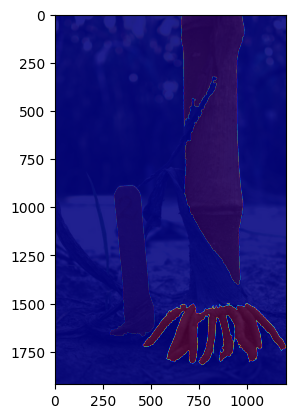

In [2]:
# Get image IDs
img_ids = coco.getImgIds()

# Get the first image
img_id = img_ids[0]
img_info = coco.loadImgs(img_id)[0]

# Load the image
img = cv2.imread('/work/images/images/' + img_info['file_name'])

# Get annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Visualize the image and segmentation masks
plt.imshow(img)
for ann in anns:
    mask = coco.annToMask(ann)
    plt.imshow(mask, cmap='jet', alpha=0.5)
plt.show()

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )



using device: cuda


In [9]:
from sam2.build_sam import build_sam2
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/opt/sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [10]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [11]:

_, out_obj_ids, out_mask_logits = predictor.add_new_mask(img, anns, sam2_model)

TypeError: SAM2VideoPredictor.add_new_mask() missing 1 required positional argument: 'mask'